# Домашняя работа №2

In [1]:
pip install razdel

In [2]:
pip install pymorphy2

     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 8.2MB 8.8MB/s 


In [15]:
import re
import numpy as np
import pandas as pd
import nltk

from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from gensim.models import LdaModel

from nltk.corpus import stopwords

from razdel import tokenize
import pymorphy2
import itertools
from ipykernel import kernelapp as app

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Наши новости

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [18]:
news = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [19]:
users = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/users_articles.csv")
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [22]:
with open('/gdrive/MyDrive/Colab Notebooks/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [23]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 27.8 s, sys: 521 ms, total: 28.3 s
Wall time: 28.5 s


In [24]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 19s, sys: 991 ms, total: 4min 20s
Wall time: 4min 22s


А теперь в 3 строчки обучим нашу модель

In [25]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [30]:
n_topic = 7

In [36]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=n_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 38.1 s, sys: 2.09 s, total: 40.1 s
Wall time: 38.1 s


In [37]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [38]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.16215855), (4, 0.13069405), (5, 0.6931699)]

In [39]:
x=lda.show_topics(num_topics=n_topic, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic, words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: nn россия сша российский рубль санкция млрд нефть банк млн
topic_1: россия украина всё российский фонд ракета вопрос nn украинский очень
topic_2: проект новый nn снижение первый погибнуть станция мозг строительство спутник
topic_3: самолёт военный сша космический корабль американский земля война россия армия
topic_4: учёный газ nn данные глава новый газета всё причина российский
topic_5: nn животное взрыв первый журнал место жизнь известный автор планета
topic_6: ребёнок россия nn исследование гражданин рост рубль первый турист наука


Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [40]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(n_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [41]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(n_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(n_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,6,0.179113,0.000000,0.568958,0.0,0.220906,0.027409,0.0
1,4896,0.000000,0.000000,0.000000,0.0,0.226194,0.756279,0.0
2,4897,0.000000,0.162167,0.000000,0.0,0.130688,0.693167,0.0
3,4898,0.000000,0.724022,0.117911,0.0,0.000000,0.151244,0.0
4,4899,0.000000,0.475599,0.166465,0.0,0.191240,0.155085,0.0


In [42]:
topic_matrix.head(20)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,6,0.179113,0.000000,0.568958,0.000000,0.220906,0.027409,0.000000
1,4896,0.000000,0.000000,0.000000,0.000000,0.226194,0.756279,0.000000
2,4897,0.000000,0.162167,0.000000,0.000000,0.130688,0.693167,0.000000
3,4898,0.000000,0.724022,0.117911,0.000000,0.000000,0.151244,0.000000
4,4899,0.000000,0.475599,0.166465,0.000000,0.191240,0.155085,0.000000
5,4900,0.000000,0.438557,0.000000,0.000000,0.000000,0.472985,0.078746
6,4901,0.000000,0.070487,0.000000,0.427320,0.000000,0.413527,0.075633
7,4902,0.411780,0.000000,0.000000,0.000000,0.000000,0.572972,0.000000
8,4903,0.000000,0.456005,0.000000,0.000000,0.000000,0.324322,0.209058
9,4904,0.000000,0.532358,0.000000,0.000000,0.000000,0.456620,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [43]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [44]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(n_topic)]].values))

In [48]:
doc_dict[293622]

array([0.22587553, 0.22122687, 0.        , 0.        , 0.        ,
       0.3576853 , 0.19058499])

In [46]:
user_articles_list = users['articles'].iloc[0]

In [78]:
def get_user_embedding(user_articles_list, function):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    print(user_vector)
    user_vector = function(user_vector, 0)
    return user_vector

In [79]:
get_user_embedding(user_articles_list, np.mean)

[[0.10447348 0.         0.60513413 0.         0.         0.
  0.27935249]
 [0.04735294 0.         0.32429114 0.         0.         0.40284535
  0.21550706]
 [0.44953427 0.28238308 0.         0.         0.         0.1186133
  0.13645096]
 [0.22587553 0.22122687 0.         0.         0.         0.3576853
  0.19058499]
 [0.41210526 0.         0.         0.04801219 0.32958296 0.
  0.2018735 ]
 [0.18424229 0.08914657 0.32085505 0.         0.33878505 0.03408599
  0.03247632]]


array([0.23726396, 0.09879275, 0.20838005, 0.00800203, 0.11139467,
       0.15220499, 0.17604088])

In [80]:
get_user_embedding(user_articles_list, np.median)

[[0.10447348 0.         0.60513413 0.         0.         0.
  0.27935249]
 [0.04735294 0.         0.32429114 0.         0.         0.40284535
  0.21550706]
 [0.44953427 0.28238308 0.         0.         0.         0.1186133
  0.13645096]
 [0.22587553 0.22122687 0.         0.         0.         0.3576853
  0.19058499]
 [0.41210526 0.         0.         0.04801219 0.32958296 0.
  0.2018735 ]
 [0.18424229 0.08914657 0.32085505 0.         0.33878505 0.03408599
  0.03247632]]


array([0.20505891, 0.04457328, 0.16042753, 0.        , 0.        ,
       0.07634964, 0.19622924])

In [81]:
get_user_embedding(user_articles_list, np.max)

[[0.10447348 0.         0.60513413 0.         0.         0.
  0.27935249]
 [0.04735294 0.         0.32429114 0.         0.         0.40284535
  0.21550706]
 [0.44953427 0.28238308 0.         0.         0.         0.1186133
  0.13645096]
 [0.22587553 0.22122687 0.         0.         0.         0.3576853
  0.19058499]
 [0.41210526 0.         0.         0.04801219 0.32958296 0.
  0.2018735 ]
 [0.18424229 0.08914657 0.32085505 0.         0.33878505 0.03408599
  0.03247632]]


array([0.44953427, 0.28238308, 0.60513413, 0.04801219, 0.33878505,
       0.40284535, 0.27935249])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [53]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.mean), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(n_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(n_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,u105138,0.237264,0.098793,0.208380,0.008002,0.111395,0.152205,0.176041
1,u108690,0.198678,0.291283,0.037619,0.029152,0.286628,0.017435,0.137108
2,u108339,0.256902,0.065491,0.151343,0.025572,0.382536,0.007280,0.106050


In [54]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.median), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(n_topic)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(n_topic)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,u105138,0.205059,0.044573,0.160428,0.000000,0.000000,0.07635,0.196229
1,u108690,0.157048,0.288875,0.037721,0.000000,0.219988,0.00000,0.052070
2,u108339,0.219356,0.047997,0.022231,0.005836,0.387880,0.00000,0.088417


In [55]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.max), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(n_topic)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(n_topic)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,u105138,0.449534,0.282383,0.605134,0.048012,0.338785,0.402845,0.279352
1,u108690,0.446776,0.570678,0.102976,0.117166,0.640331,0.053000,0.610935
2,u108339,0.549527,0.170825,0.467003,0.082670,0.600781,0.043678,0.235800


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [56]:
target = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/users_churn.csv")
target.head(5)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


## Посмотрим сначала со средним, потом с медианой, а потом с max

In [57]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,churn
0,u105138,0.237264,0.098793,0.208380,0.008002,0.111395,0.152205,0.176041,0
1,u108690,0.198678,0.291283,0.037619,0.029152,0.286628,0.017435,0.137108,1
2,u108339,0.256902,0.065491,0.151343,0.025572,0.382536,0.007280,0.106050,1


In [58]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(n_topic)]], 
                                                    X['churn'], random_state=0)

In [59]:
logreg_mean = LogisticRegression()
#обучим 
logreg_mean.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
X_test.shape

(2000, 7)

In [61]:
#наши прогнозы для тестовой выборки
preds_mean = logreg_mean.predict_proba(X_test)[:, 1]
preds_mean

array([0.04339759, 0.01064895, 0.41334706, ..., 0.00888411, 0.12632276,
       0.03801411])

### Рассчитаем Precision, Recall, F_score

In [65]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds_mean)
precision_mean = [p[p!=0] for p in precision_mean]
precision_mean = np.asarray(precision_mean)
recall_mean = [p[p!=0] for p in recall_mean]
recall_mean = np.asarray(recall_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))
print(f'Roc_Auc={roc_auc_score(y_test, preds_mean)}')

<class 'numpy.ndarray'>
Best Threshold=0.200537, F-Score=0.475, Precision=0.361, Recall=0.694
Roc_Auc=0.8556125356125356


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<function matplotlib.pyplot.show>

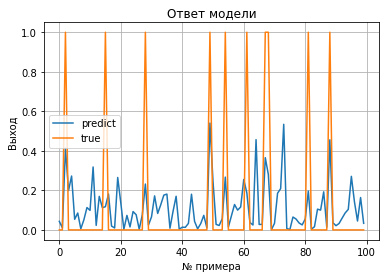

In [64]:
plt.plot(preds_mean[:100], label='predict')
plt.plot(y_test.values[:100], label='true')
plt.title('Ответ модели')
plt.xlabel('№ примера')
plt.ylabel('Выход')
plt.legend()
plt.grid('On')
plt.show

Confusion matrix, without normalization
[[1454  301]
 [  76  169]]


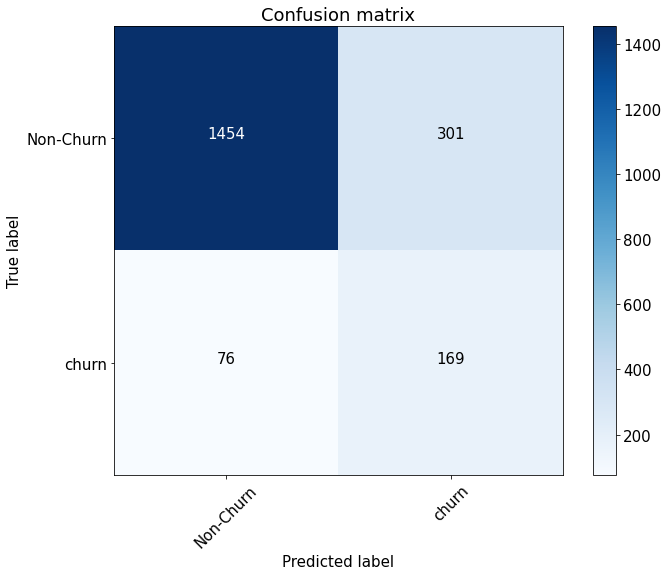

In [68]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_mean>thresholds_mean[ix_mean])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [69]:
X = pd.merge(user_embeddings_median, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(n_topic)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds_median = logreg.predict_proba(X_test)[:, 1]

precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))
print(f'Roc_Auc={roc_auc_score(y_test, preds_median)}')

Best Threshold=0.199772, F-Score=0.491, Precision=0.374, Recall=0.714
Roc_Auc=0.8658410372696088


Confusion matrix, without normalization
[[1462  293]
 [  71  174]]


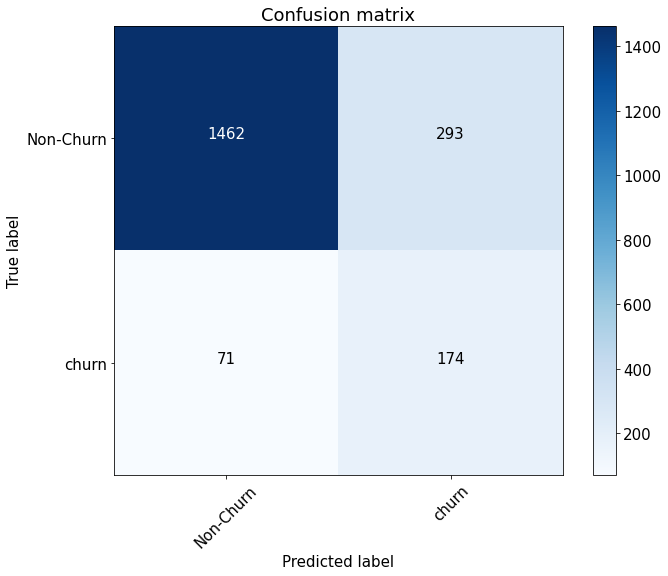

In [71]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [75]:
X = pd.merge(user_embeddings_max, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(n_topic)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds_max = logreg.predict_proba(X_test)[:, 1]

precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds_max)
precision_max = [p[p!=0] for p in precision_max]
precision_max = np.asarray(precision_max)
recall_mean = [p[p!=0] for p in recall_mean]
recall_mean = np.asarray(recall_mean)

fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))
print(f'Roc_Auc={roc_auc_score(y_test, preds_max)}')

Best Threshold=0.217735, F-Score=0.462, Precision=0.364, Recall=0.633
Roc_Auc=0.8250944822373395


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Confusion matrix, without normalization
[[1484  271]
 [  91  154]]


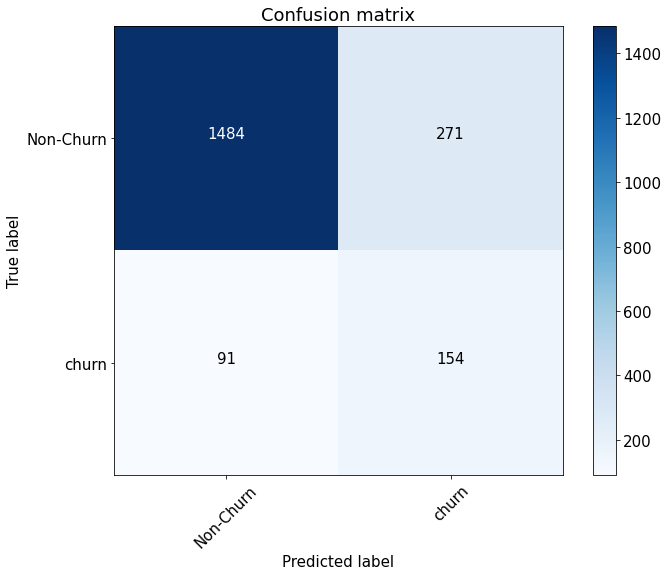

In [76]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [77]:
print('Mean\nBest Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))
print('Median\nBest Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))
print('Max\nBest Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Mean
Best Threshold=0.200537, F-Score=0.475, Precision=0.361, Recall=0.694
Median
Best Threshold=0.199772, F-Score=0.491, Precision=0.374, Recall=0.714
Max
Best Threshold=0.217735, F-Score=0.462, Precision=0.364, Recall=0.633


У меня precision и recall содержат 0, из-за этого не считался F-Score. Я убрал нули, однако качество модели оставляет желать лучшего. Подскажите пожалуйста, что я сделал не так? 

Вывод делать по таким данным затруднительно, однако, как мне кажется, в споре между max mean и median, лучшую точность показал бы median, т.к. при max мы теряем много информации от "не выбранных" топиков, а mean сильно занизит оценку, если один из векторов статьи 0.